In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import os, glob, random, shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, concatenate, MaxPool2D, Input, Dropout
from tensorflow.keras.models import Model, save_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall


In [14]:
IMG_DIR = "data/images"
MSK_DIR = "data/masks"

BATCH_SIZE = 32
EPOCHS = 20
LR = 1e-4

# MODEL_TYPE = "attention"   # "unet" hoặc "attention"
MODEL_TYPE = "Unet"
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Khớp ảnh / mask

In [15]:
# Get all image and mask files
image_files = sorted(glob.glob(os.path.join(IMG_DIR, '*.jpg')))
mask_files = sorted(glob.glob(os.path.join(MSK_DIR, '*.png')))

# Match by filename
image_basename_to_path = {os.path.basename(f): f for f in image_files}
mask_basename_to_path = {os.path.basename(f): f for f in mask_files}

# Strip extensions for matching
image_keys = {os.path.splitext(f)[0] for f in image_basename_to_path.keys()}
mask_keys = {os.path.splitext(f)[0] for f in mask_basename_to_path.keys()}

# Only keep pairs that exist in both directories
common_keys = image_keys & mask_keys

# Recreate matched image and mask pairs with valid extensions
image_paths = [image_basename_to_path[f"{k}.jpg"] for k in common_keys]
mask_paths = [mask_basename_to_path[f"{k}.png"] for k in common_keys]


In [16]:
# Sort for reproducibility
image_paths.sort()
mask_paths.sort()

train / val / test = 70 / 10 / 20

In [17]:
train_images, test_images, train_masks, test_masks = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.1, random_state=42
)

print(f"Train: {len(train_images)}")
print(f"Val: {len(val_images)}")
print(f"Test: {len(test_images)}")

Train: 7210
Val: 802
Test: 2003


Tf.data

In [18]:
def load_image_mask_pairs(image_paths, mask_paths):
    images = tf.io.read_file(image_paths)
    images = tf.image.decode_jpeg(images, channels=3)
    images = tf.image.resize(images, [128, 128])  # resolution
    images = tf.cast(images, tf.float32) / 255.0

    masks = tf.io.read_file(mask_paths)
    masks = tf.image.decode_png(masks, channels=1)
    masks = tf.image.resize(masks, [128, 128])
    # binarize mask
    masks = tf.cast(masks > 127, tf.float32)
    return images, masks

def augment_image_mask(images, masks):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        images = tf.image.flip_left_right(images)
        masks  = tf.image.flip_left_right(masks)
    # Random vertical flip
    if tf.random.uniform(()) > 0.5:
        images = tf.image.flip_up_down(images)
        masks  = tf.image.flip_up_down(masks)
    # Random 0/90/180/270 rotation (keeps masks crisp)
    k = tf.random.uniform((), minval=0, maxval=4, dtype=tf.int32)
    images = tf.image.rot90(images, k)
    masks  = tf.image.rot90(masks, k)
    # Mild brightness jitter (image only)
    images = tf.image.random_brightness(images, max_delta=0.15)
    images = tf.clip_by_value(images, 0.0, 1.0)
    return images, masks

def get_dataset(image_paths, mask_paths, batch_size=32, training=False):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    dataset = dataset.map(load_image_mask_pairs, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.map(augment_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_dataset = get_dataset(train_images, train_masks, training=True)
test_dataset  = get_dataset(test_images,  test_masks,  training=False)
val_dataset   = get_dataset(val_images,   val_masks,   training=False)


visualizng a sample

In [19]:
def display_sample(images):
    plt.figure(figsize=(10,10))
    titles = ['Input Image','True Mask','Predicted Mask']

    for i in range(len(images)):
        plt.subplot(1,len(images),i+1)
        plt.title(titles[i])
        plt.imshow(array_to_img(images[i]))
        plt.axis('off')

    plt.show()

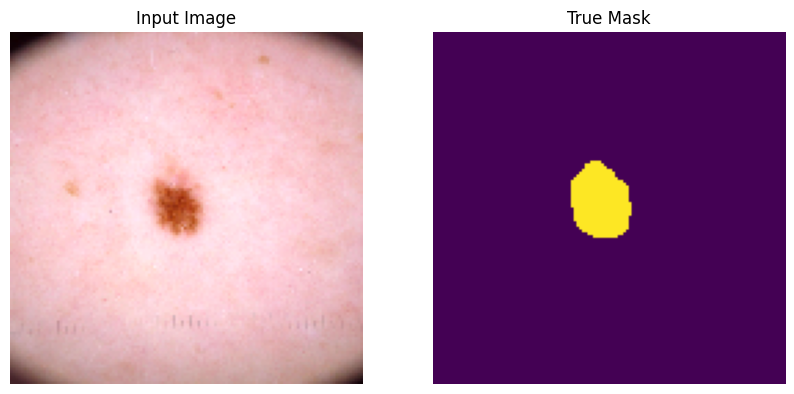

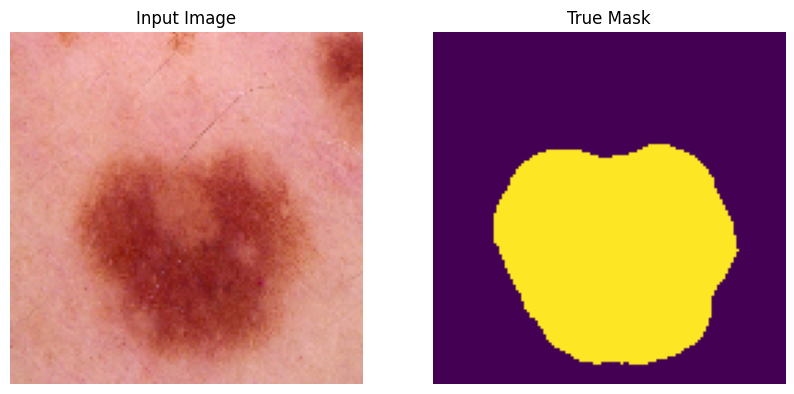

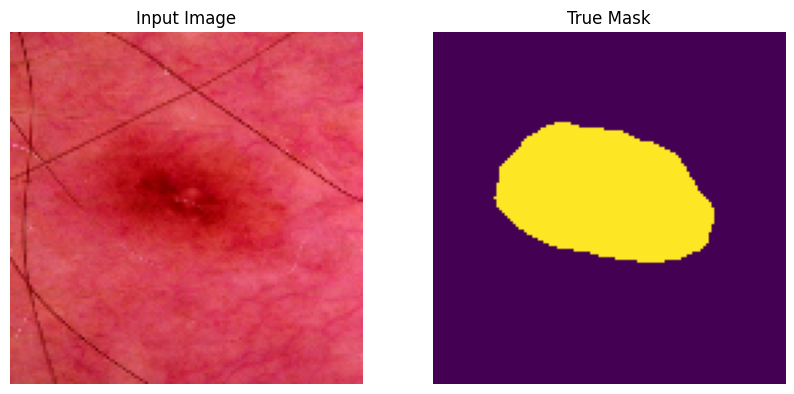

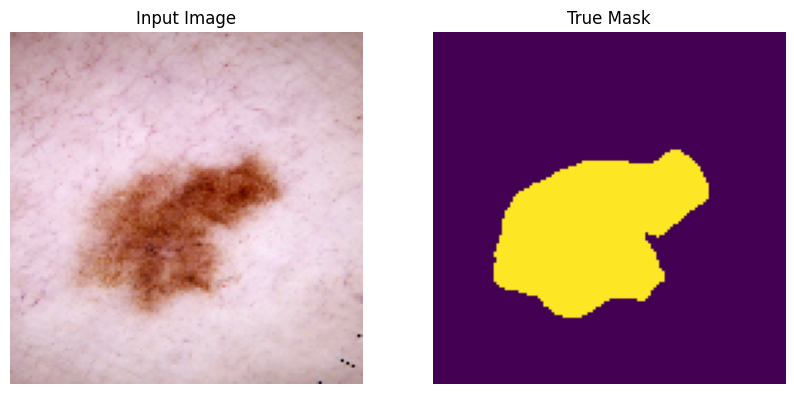

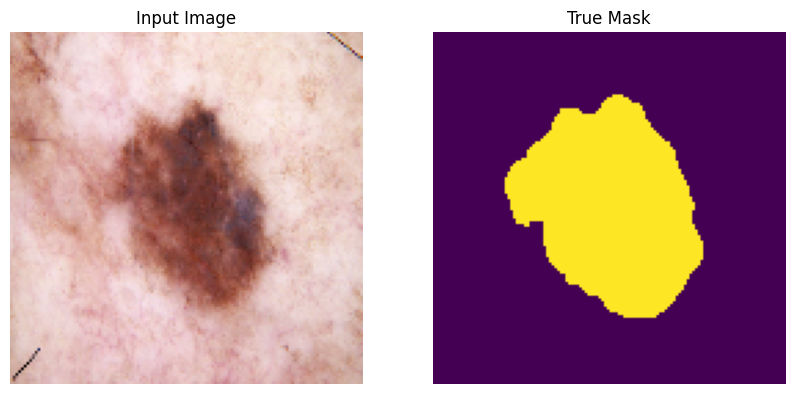

In [20]:
for images, masks in train_dataset.take(5):
    sample_image, sample_mask = images[0], masks[0]
    display_sample([sample_image, sample_mask])

In [21]:
sample_image.shape

TensorShape([128, 128, 3])

In [22]:
# Enhanced Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.7, 1.3]  # Added brightness variations
)

Loss/Metric (Dice + IoU)

In [23]:
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

# --- Losses & Metrics (binary segmentation) ---
def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denom = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = (2.0 * intersection + smooth) / (denom + smooth)
    return tf.reduce_mean(dice)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou_coef(y_true, y_pred, smooth=1e-5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    y_pred = tf.clip_by_value(y_pred, 0.0, 1.0)

    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return tf.reduce_mean(iou)

def iou_loss(y_true, y_pred):
    return 1.0 - iou_coef(y_true, y_pred)

# A common strong baseline: BCE + Dice
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def combined_loss(y_true, y_pred):
    return bce(y_true, y_pred) + dice_loss(y_true, y_pred)

# --- Optimizer + LR scheduler ---
optimizer = AdamW(learning_rate=1e-4, weight_decay=1e-5)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6)


U-Net

In [24]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, UpSampling2D, Input, Conv2DTranspose, concatenate, Add, BatchNormalization
def double_conv_block(x, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters=n_filters, kernel_size=(3,3), activation='relu', padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    return x

def downsample_block(x, n_filters):
    fwd_block = double_conv_block(x=x, n_filters=n_filters)
    x = MaxPool2D((2,2))(fwd_block)
    x = Dropout(0.3)(x)
    return fwd_block, x

def upsample_block(x, conv_features, n_filters):
    x = Conv2DTranspose(filters=n_filters, kernel_size=(3,3), strides=2, padding='same')(x)
    x = concatenate([x, conv_features])
    x = Dropout(0.3)(x)
    x = double_conv_block(x, n_filters)
    return x

def build_unet_model(output_channels):
    inputs = Input(shape=(128, 128, 3))

    # encoder block - compress images - contracting path - downsampling
    f1, p1 = downsample_block(inputs,64)
    f2, p2 = downsample_block(p1,128)
    f3, p3 = downsample_block(p2,256)
    f4, p4 = downsample_block(p3,512)

    # intermediate block - bridge - contains higher level features - highly compressed
    intermediate_block = double_conv_block(p4,1024)

    # decoder block - upsampling - concatenates encoder features for precise localization
    u6 = upsample_block(intermediate_block,f4,512)
    u7 = upsample_block(u6,f3,256)
    u8 = upsample_block(u7,f2,128)
    u9 = upsample_block(u8,f1,64)

    outputs = Conv2D(output_channels,1,activation='sigmoid',padding='same')(u9)
    unet_model = Model(inputs,outputs,name='U-Net')
    return unet_model

output_channels = 1
unet_model = build_unet_model(output_channels)
unet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall()])
unet_model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_5[0][0]  

 Total params: 34,536,897 (131.75 MB)

 Trainable params: 34,525,121 (131.70 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [ ]:
from tensorflow.keras.metrics import Precision, Recall
import tensorflow as tf

unet_model.compile(
    optimizer=optimizer,
    loss=combined_loss,
    metrics=[
        'accuracy',          # can be misleading for segmentation, keep for reference
        dice_coef,           # more meaningful
        iou_coef,            # more meaningful
        Precision(),
        Recall()
    ]
)

history = unet_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[lr_scheduler]
)

evaluation_result = unet_model.evaluate(test_dataset)

test_loss = evaluation_result[0]


Epoch 1/20
  3/226 ━━━━━━━━━━━━━━━━━━━━ 47:40 13s/step - accuracy: 0.4467 - dice_coef: 0.2895 - iou_coef: 0.1797 - loss: 1.6643 - precision_1: 0.2318 - recall_1: 0.4648

In [21]:
res = unet_model.evaluate(val_dataset, verbose=0, return_dict=True)
print(res)

{'accuracy': 0.9678746461868286, 'dice_coef': 0.9270613193511963, 'iou_coef': 0.8730040192604065, 'loss': 0.1654350459575653, 'precision_1': 0.9401043653488159, 'recall_1': 0.9355542063713074}


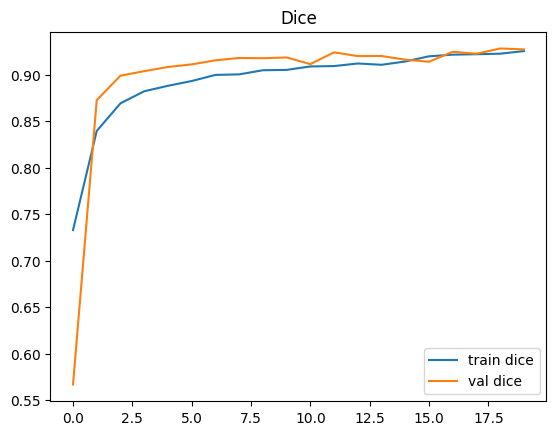

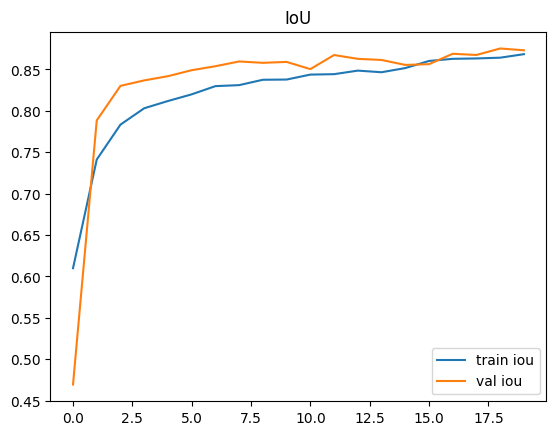

In [19]:
plt.figure()
plt.plot(history.history['dice_coef'], label='train dice')
plt.plot(history.history['val_dice_coef'], label='val dice')
plt.legend(); plt.title("Dice"); plt.show()

plt.figure()
plt.plot(history.history['iou_coef'], label='train iou')
plt.plot(history.history['val_iou_coef'], label='val iou')
plt.legend(); plt.title("IoU"); plt.show()

In [10]:
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

NameError: name 'history' is not defined

visualizing model performance

In [8]:
plt.plot(history.history['loss'],'r',label='train loss')
plt.plot(history.history['val_loss'],'b',label='test loss')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend()
plt.show();

NameError: name 'plt' is not defined

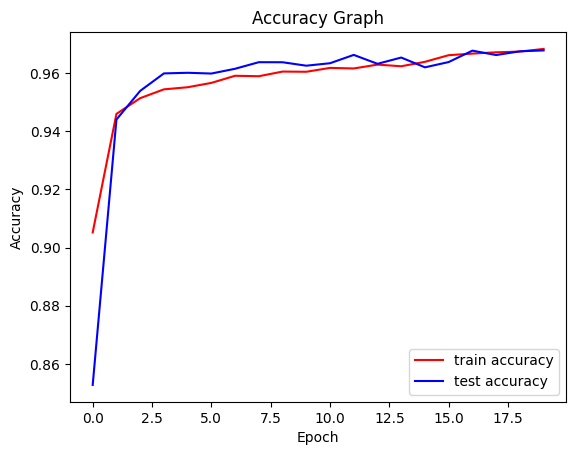

In [15]:
plt.plot(history.history['accuracy'],'r',label='train accuracy')
plt.plot(history.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.show();

make a predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


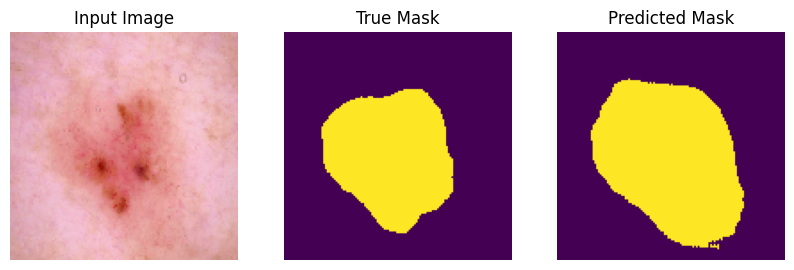

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


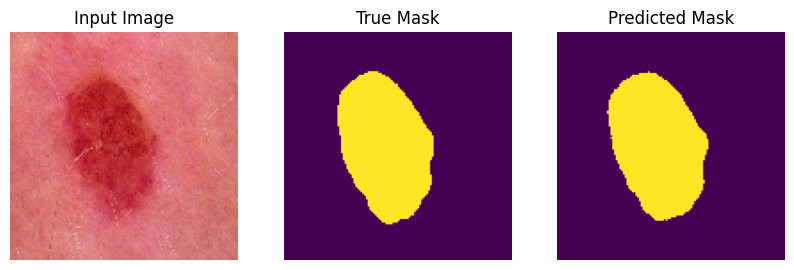

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


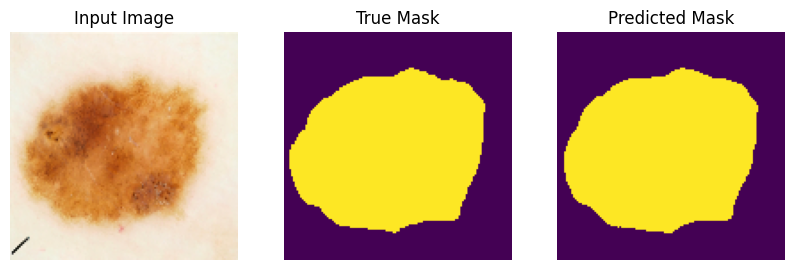

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


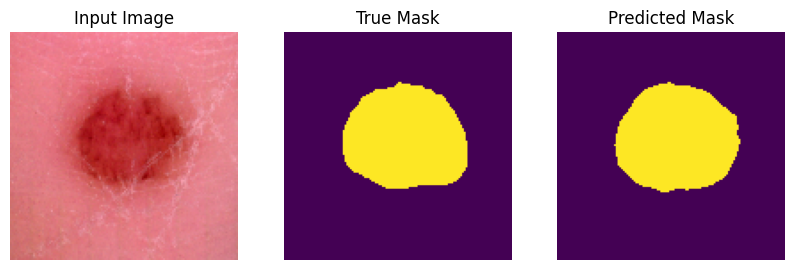

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


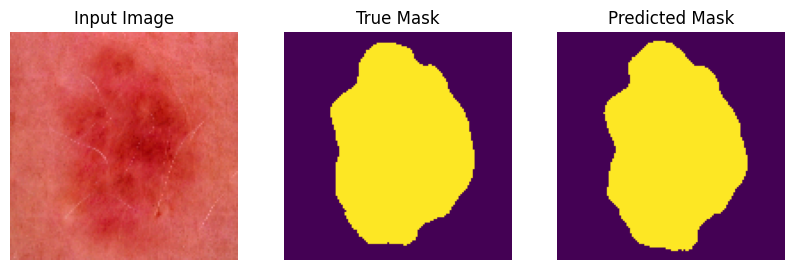

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


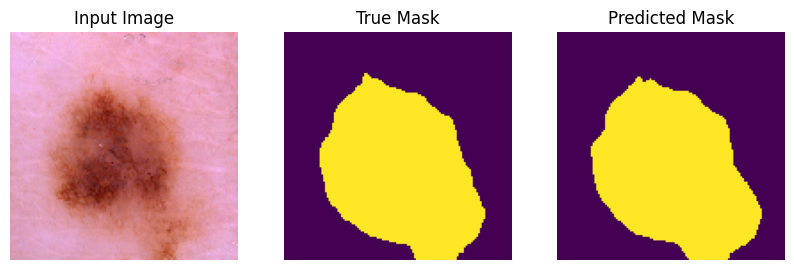

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


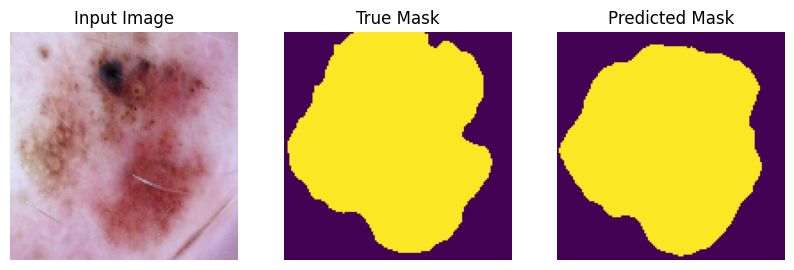

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


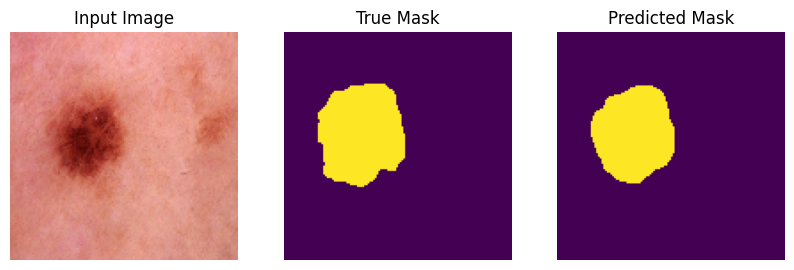

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


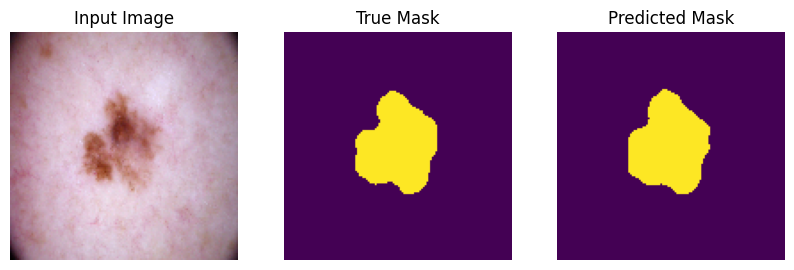

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


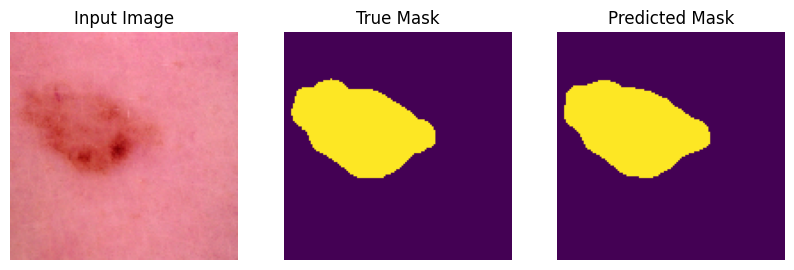

In [16]:
def create_prediction_mask(prediction_mask, batch_idx, thr=0.5):
    # prediction_mask: (B, H, W, 1) with sigmoid probabilities
    pred = prediction_mask[batch_idx]
    pred = tf.cast(pred > thr, tf.float32)
    return pred

def segment_image(dataset=None, num=1, thr=0.5):
    if dataset:
        for images, masks in dataset.take(num):
            prediction_masks = unet_model.predict(images)
            display_sample([images[0], masks[0], create_prediction_mask(prediction_masks, 0, thr=thr)])

segment_image(dataset=val_dataset, num=10, thr=0.5)